In [439]:
import pandas as pd
import numpy as np

In [440]:
%matplotlib inline
import matplotlib.pylab as plt

In [441]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [531]:
from pdkit.gait_time_series import GaitTimeSeries
from pdkit.gait_processor import GaitProcessor
from pdkit.utils import butter_lowpass_filter

In [443]:
file = '/home/c/data/pdkit/GAIT_-_2018-06-14_13-50-58_-_d90b653403_-_13311.csv'

In [444]:
d = pd.read_csv(file)

In [445]:
d.x -= d.x.mean()
d.y -= d.y.mean()
d.z -= d.z.mean()

d.r1 -= d.r1.mean()
d.r2 -= d.r2.mean()
d.r3 -= d.r3.mean()

In [446]:
time_diff = (d.time - d.time[0]) / 1000000000.0
date_time = pd.to_datetime(d.time - d.time[0])
mag_acc_sum = np.sqrt(d.x ** 2 + d.y ** 2 + d.z ** 2)

d['mag_sum_acc'] = mag_acc_sum
d['td'] = time_diff
d.index = date_time
del d.index.name
d.drop(columns=['time'], inplace=True)

In [447]:
d.head()

,x,y,z,r1,r2,r3,mag_sum_acc,td
1970-01-01 00:00:00.000,1.079033,0.391372,0.666694,0.162495,-0.896423,-0.030430,1.327390,0.000
1970-01-01 00:00:00.002,1.165226,0.465595,0.731339,0.159440,-0.940405,-0.024322,1.452373,0.002
1970-01-01 00:00:00.004,1.227478,0.602068,0.784014,0.169214,-1.035700,-0.020657,1.576028,0.004
1970-01-01 00:00:00.006,1.390288,0.803187,0.956401,0.174101,-1.132827,-0.021878,1.868880,0.006
1970-01-01 00:00:00.008,1.390288,0.803187,0.956401,0.177155,-1.179864,-0.023711,1.868880,0.008


In [448]:
data = GaitTimeSeries.load_data(file, format_file='gait_gyro')
gp = GaitProcessor()

In [450]:
def calculate_static_signal(signal, frequency=100, thresh=0.1, cutoff=2, order=3):

    signal = butter_lowpass_filter(signal, frequency, cutoff=cutoff, order=order)
    
    for i, s in enumerate(signal):
        if not (-thresh <= s <= thresh):
            start = i
            break
    
    for i, s in reversed(list(enumerate(signal))):
        if not (-thresh <= s <= thresh):
            stop = i
            break
            
    return start, stop

starts = []
stops = []

for a in ['x', 'y']:
    signal = data[a].values
    start, stop = calculate_static_signal(signal, thresh=0.5)
    
    starts.append(start)
    stops.append(stop)

start = np.mean(starts, dtype=np.int)
stop = np.mean(stops, dtype=np.int)

In [456]:
start, stop = calculate_static_signal(data.y.values, thresh=0.4)

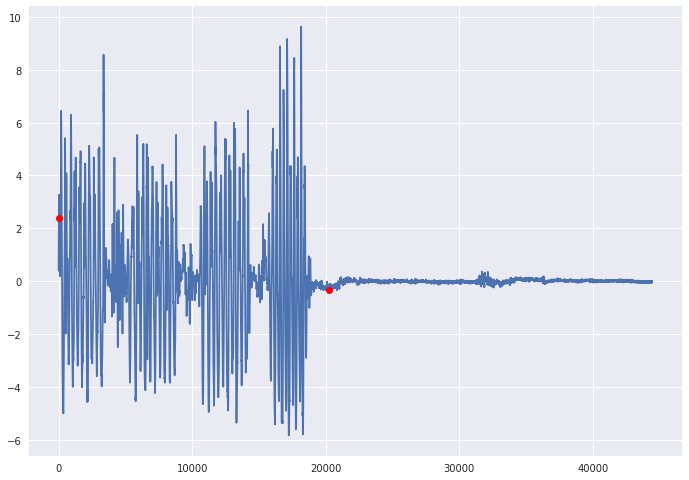

In [457]:
plt.plot(signal)
plt.plot(start, signal[start], 'ro')
plt.plot(stop, signal[stop], 'ro')

In [458]:
data = data[start:stop]

In [459]:
data.td -= data.td[0]

In [460]:
data.index -= data.index[0]

In [461]:
data.index = pd.to_datetime(data.td * 1000000000.0)
del data.index.name

In [532]:
newdata = gp.resample_signal(data)

In [538]:
data.index.second.value_counts().sort_index()

0     500
1     499
2     500
3     500
4     499
5     500
6     500
7     499
8     500
9     500
10    499
11    500
12    500
13    499
14    500
15    500
16    499
17    500
18    500
19    499
20    500
21    500
22    499
23    500
24    500
25    499
26    500
27    500
28    499
29    500
30    500
31    500
32    499
33    500
34    499
35    500
36    500
37    499
38    500
39    500
40    206
dtype: int64

In [539]:
newdata.index.second.value_counts().sort_index()

0     100
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29    100
30    100
31    100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40     42
dtype: int64

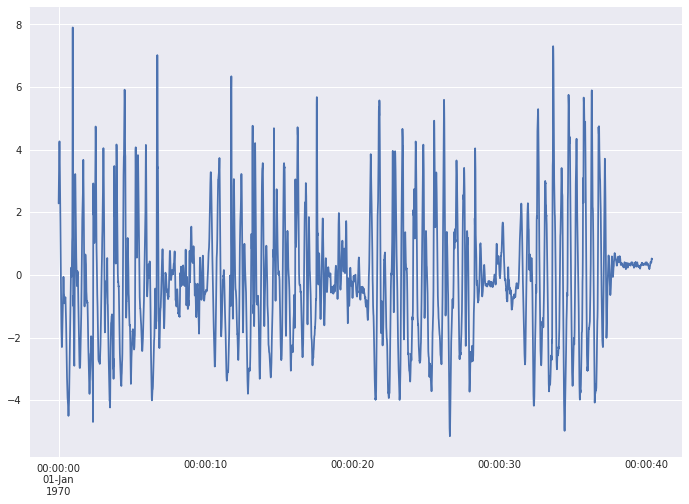

In [463]:
newdata.x.plot()

In [464]:
from utils import butter_lowpass_filter

In [465]:
xx = butter_lowpass_filter(newdata.x.values, sample_rate=100, cutoff=2, order=4)

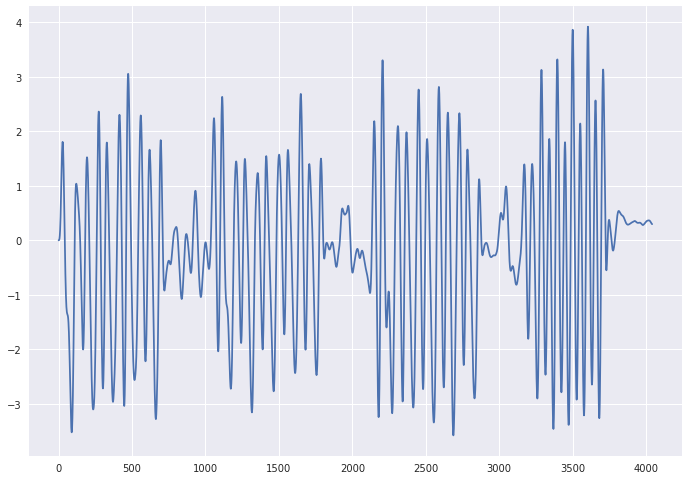

In [466]:
plt.plot(xx)
#plt.plot(newdata.x.values)

In [467]:
import scipy.signal as  sig

In [468]:
pk = sig.find_peaks(xx, height=[-10, 10])[0]

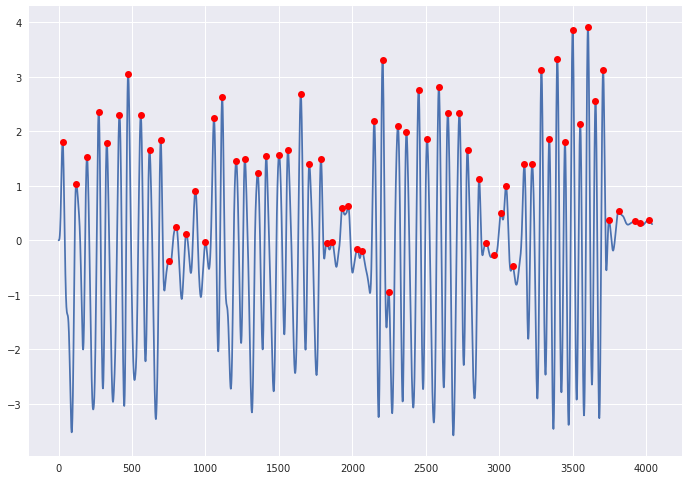

In [469]:
plt.plot(xx)
plt.plot(pk, xx[pk], 'ro')

## First approach, look at top and bottom peaks and get the ones between -1 and 1

In [470]:
top = sig.argrelextrema(xx, np.greater)[0]
bot = sig.argrelextrema(xx, np.less)[0]

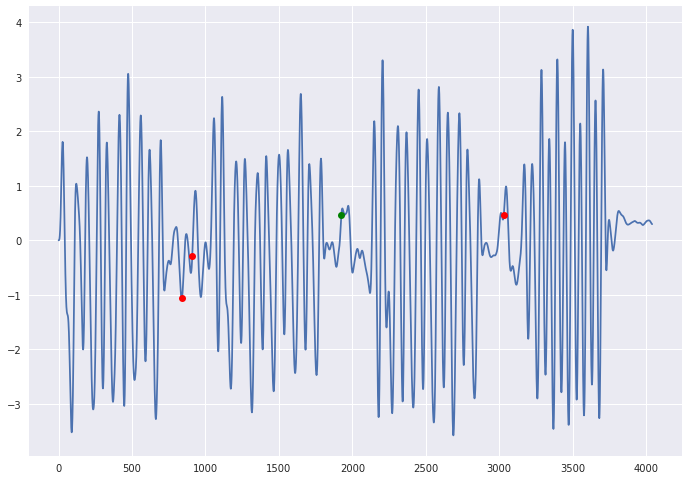

In [509]:
plt.plot(xx)
plt.plot(top, xx[top], 'ro')
plt.plot(bot, xx[bot], 'go')

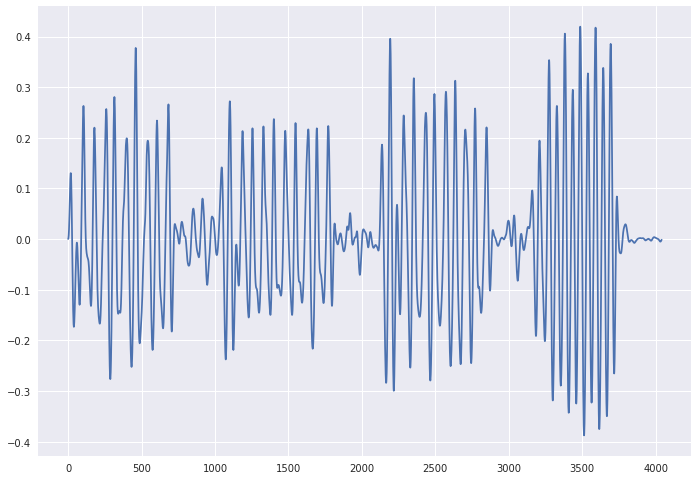

In [510]:
plt.plot(np.gradient(xx))

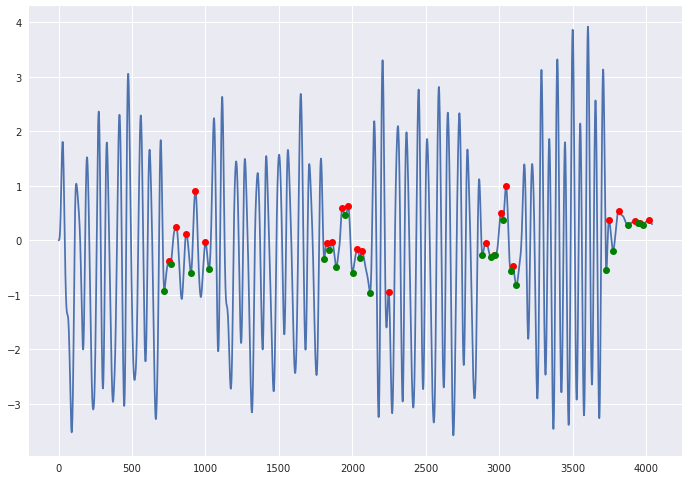

In [472]:
plt.plot(xx)
plt.plot(top[xx[top] < 1], xx[top[xx[top] < 1]], 'ro')
plt.plot(bot[xx[bot] > -1], xx[bot[xx[bot] > -1]], 'go')

As you can see we also get some peaks that do not belong to turns. These are in the middle of walking sections of the signal and should not be piked up.

In [422]:
def get_peaks_valleys(data):
    top = sig.argrelextrema(data, np.greater)[0]
    bot = sig.argrelextrema(data, np.less)[0]
    
    return top, bot

def get_turns_with_thresh(data, thresh=[-1, 1]):
    top, bot = get_peaks_valleys(data)
    
    top = top[data[top] < np.max(thresh)]
    bot = bot[data[bot] > np.min(thresh)]
    
    return top, bot

In [423]:
tops, bots = get_turns_with_thresh(xx)

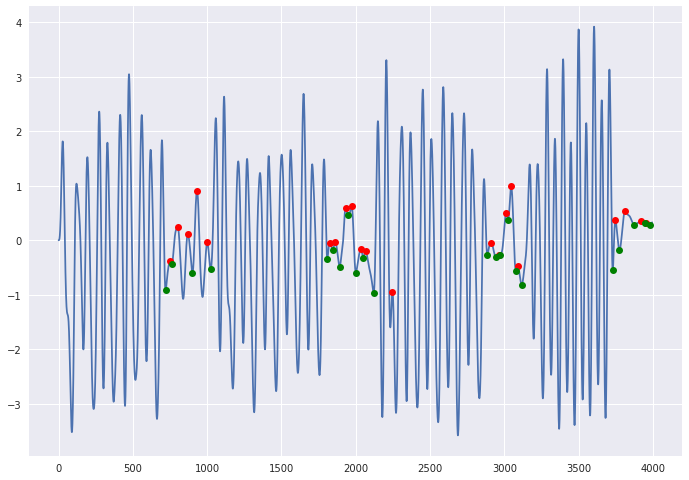

In [424]:
plt.plot(xx)
plt.plot(tops, xx[tops], 'ro')
plt.plot(bots, xx[bots], 'go')

## Second approach: get the trend of the distance between top and bottom peaks and use that as a threshold for turning.

In [476]:
top, bot = get_peaks_valleys(xx)

differences = xx[top[:-1]] - xx[bot]
differences

array([5.32493412e+00, 3.03965326e+00, 4.62234981e+00, 5.07613327e+00,
       4.75387878e+00, 5.33790467e+00, 5.61346838e+00, 4.50756310e+00,
       4.93994308e+00, 2.75796864e+00, 6.73570737e-02, 1.32059516e+00,
       7.13602971e-01, 1.94877180e+00, 4.87843428e-01, 4.27354562e+00,
       5.35158612e+00, 3.32884271e+00, 4.64759417e+00, 3.23414277e+00,
       4.31132203e+00, 3.29398688e+00, 4.09057215e+00, 4.68879624e+00,
       3.86916213e+00, 1.83336607e+00, 1.25180140e-01, 4.52769097e-01,
       1.15492221e-01, 1.22772844e+00, 1.69524641e-01, 7.77383278e-01,
       5.42573775e+00, 4.89931496e+00, 2.23173951e+00, 5.04873333e+00,
       5.04699550e+00, 5.49108684e+00, 5.19625119e+00, 5.50894924e+00,
       5.91695848e+00, 4.61594928e+00, 4.56161015e+00, 1.39411428e+00,
       2.62999366e-01, 3.08129346e-03, 1.23615137e-01, 1.54702294e+00,
       3.42593384e-01, 3.19672044e+00, 4.30015532e+00, 5.58866326e+00,
       5.31656536e+00, 6.10186353e+00, 5.18143039e+00, 6.78114722e+00,
      

In [477]:
turns_top = []
turns_bot = []

for i, d in enumerate(differences):
    if d < 1.5:
        turns_top.append(top[i])
        turns_bot.append(bot[i])

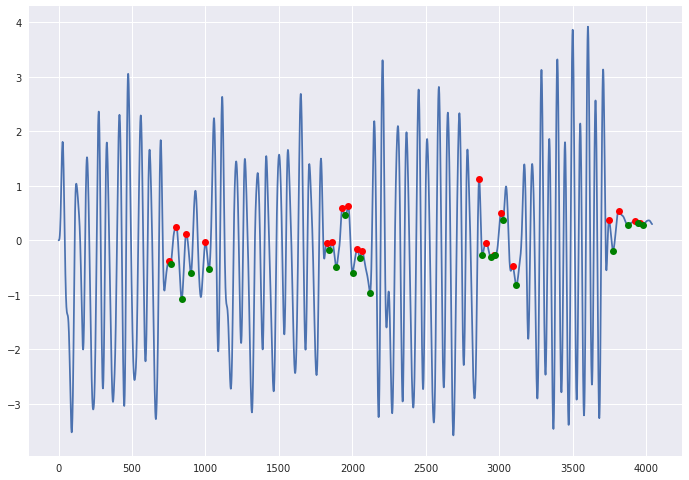

In [478]:
plt.plot(xx)
plt.plot(turns_top, xx[turns_top], 'ro')
plt.plot(turns_bot, xx[turns_bot], 'go')

This approach seems more robust, although we should define some turning dynamics. We could also use the inverse and get the walking sections instead of the turns.

In [474]:
def get_turns_from_distance(data, max_distance=1.5):
    top, bot = get_peaks_valleys(xx)
    
    differences = xx[top] - xx[bot]
    
    turns_top = []
    turns_bot = []
    
    for i, d in enumerate(differences):
        if d < max_distance:
            turns_top.append(top[i])
            turns_bot.append(bot[i])
            
    return turns_top, turns_bot

In [475]:
tt, tb = get_turns_from_distance(xx)

ValueError: operands could not be broadcast together with shapes (65,) (64,) 

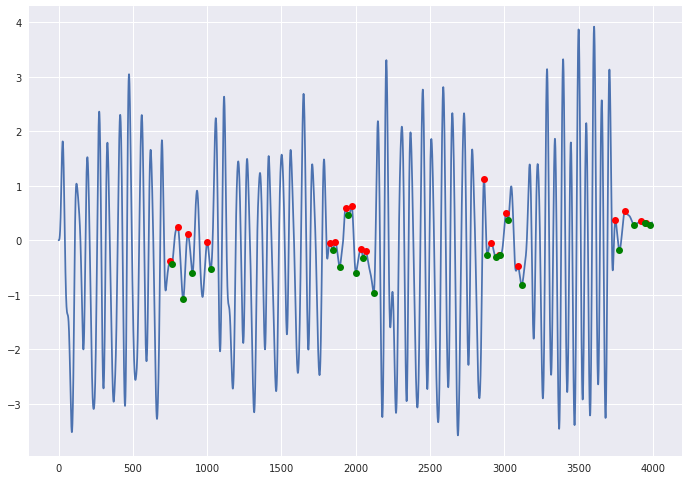

In [430]:
plt.plot(xx)
plt.plot(tt, xx[tt], 'ro')
plt.plot(tb, xx[tb], 'go')

## Separate turns into regions

In [479]:
regions_top = [i for i,d in enumerate(np.ediff1d(turns_top)) if d > 200]
regions_bot = [i for i,d in enumerate(np.ediff1d(turns_bot)) if d > 200]
regions_top, regions_bot

([3, 9, 14], [3, 9, 14])

In [480]:
def extract_turning_regions(turns, min_distance=200):
    
    regions = [i for i,d in enumerate(np.ediff1d(turns)) if d > min_distance]
    
    turn_regions = []

    for i, r in enumerate(regions):
        if i == 0:
            start = 0
            end = r + 1
        else:
            
            start = end
            end = r + 1

        turn_regions.append(turns[start: end])
        
    return turn_regions

In [481]:
turn_top_regions = extract_turning_regions(turns_top)
turn_bot_regions = extract_turning_regions(turns_bot)

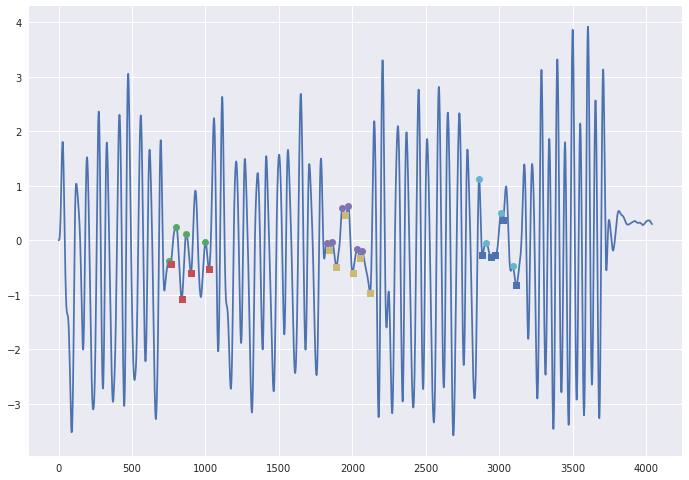

In [482]:
plt.plot(xx)
for t,b in zip(turn_top_regions, turn_bot_regions):
    plt.plot(t, xx[t], 'o')
    plt.plot(b, xx[b], 's')

## Third approach: 

In [127]:
regions = []

for i, d in enumerate(np.ediff1d(pk)):
    if d > 200:
        regions += [i]

In [128]:
regions

[8, 13, 17]

In [129]:
pk[:]

array([ 743,  775,  825,  860,  890,  920,  958,  989, 1010, 1845, 1966,
       2005, 2049, 2097, 2914, 2939, 3023, 3085, 3763, 3828, 3878, 3957])

In [130]:
turns = []

for i, r in enumerate(regions):
    if i == 0:
        start = 0
        end = r + 1
    else:
        start = end
        end = r + 1
        
    turns.append(pk[start: end])

In [131]:
turns

[array([ 743,  775,  825,  860,  890,  920,  958,  989, 1010]),
 array([1845, 1966, 2005, 2049, 2097]),
 array([2914, 2939, 3023, 3085])]

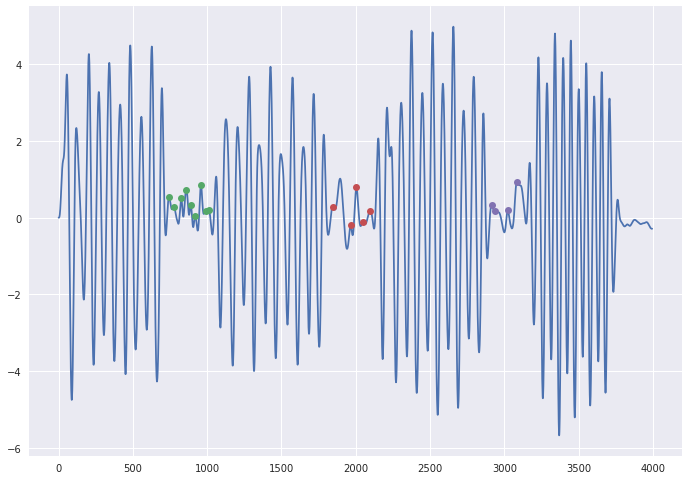

In [132]:
plt.plot(xx)
for t in turns:
    plt.plot(t, xx[t], 'o')

In [90]:
regions

[]

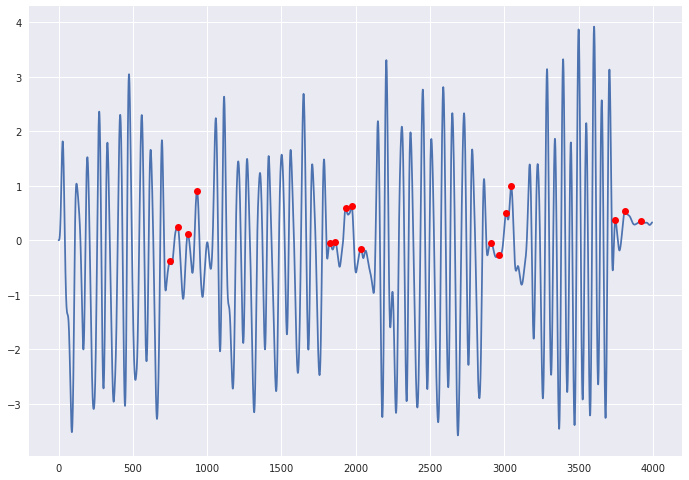

In [84]:
plt.plot(xx)
plt.plot(new_pk, xx[new_pk], 'ro')

In [183]:
def get_turning_regions(data, sample_rate=100):
    
    signal = butter_lowpass_filter(data, sample_rate=sample_rate, cutoff=2, order=4)
    pk = sig.find_peaks(signal, height=[-1, 1])[0]
    
    regions = []

    for i, d in enumerate(np.ediff1d(pk)):
        if d > 200:
            regions += [i]
            
    turns = []

    for i, r in enumerate(regions):
        if i == 0:
            start = 0
            end = r + 1
        else:
            start = end
            end = r + 1

        turns.append(pk[start: end])
        
    plt.plot(xx)
    for t in turns:
        plt.plot(t, xx[t], 'o')
        
    return turns

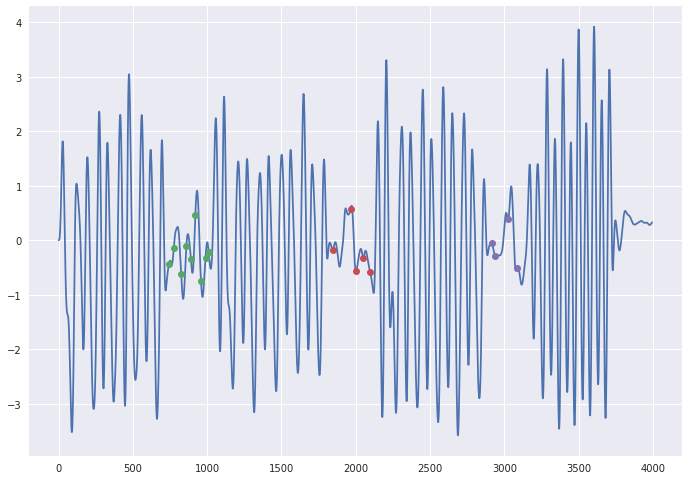

In [184]:
turns = get_turning_regions(newdata.y.values)

In [186]:
for t in turns:
    the_time = newdata.td[t[0]: t[-1]].values
    the_time -= the_time[0]
    print(the_time[-1])

2.660000000000003
2.509999999999998
1.7010000000000005


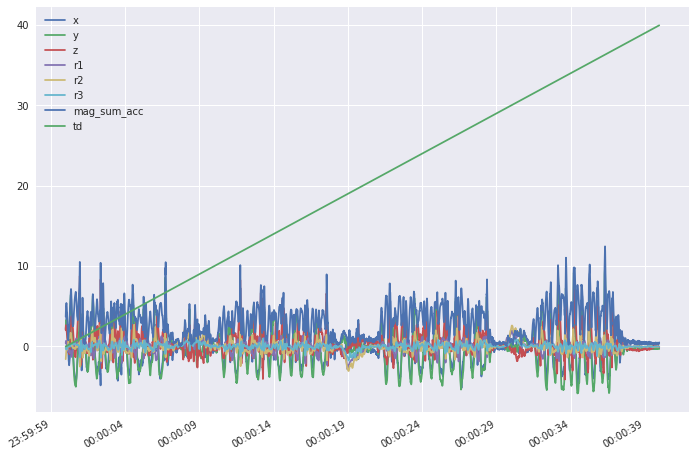

In [187]:
data.plot()

In [436]:
peaks = sig.find_peaks(xx, height=2)[0]
p, l, r = sig.peak_prominences(xx, pk)

## Using gyro data

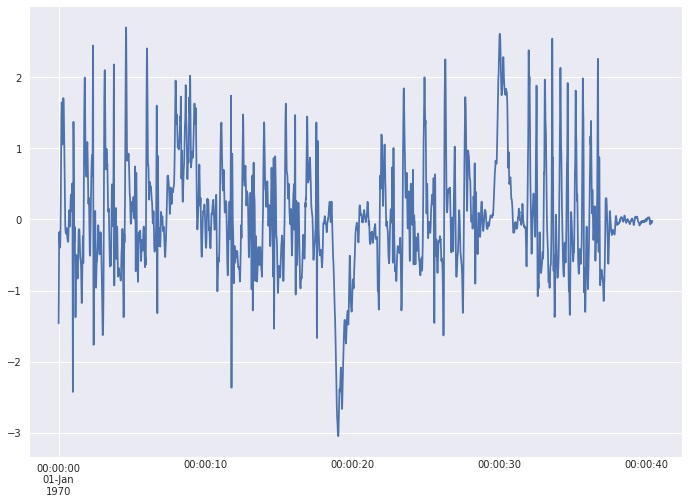

In [484]:
newdata.r2.plot()

In [525]:
rr1 = butter_lowpass_filter(newdata.r1.values, sample_rate=100, cutoff=2, order=4)
rr2 = butter_lowpass_filter(newdata.r2.values, sample_rate=100, cutoff=2, order=4)
rr3 = butter_lowpass_filter(newdata.r3.values, sample_rate=100, cutoff=2, order=4)

rrr = rr1 * rr2 * rr3 # hadamard product (schur product)

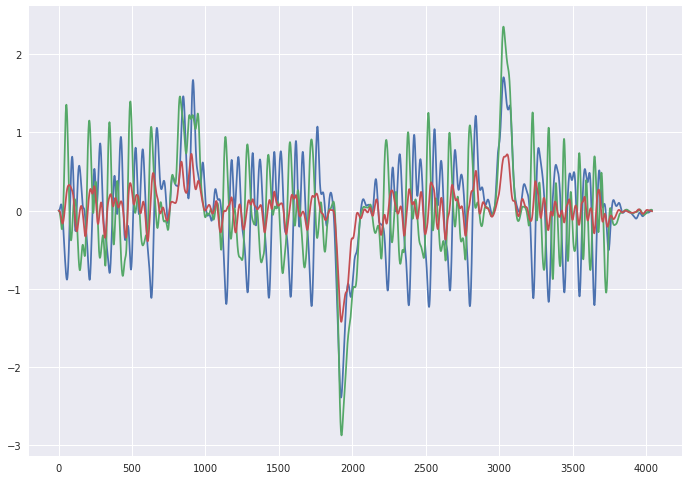

In [526]:
plt.plot(rr1)
plt.plot(rr2)
plt.plot(rr3)

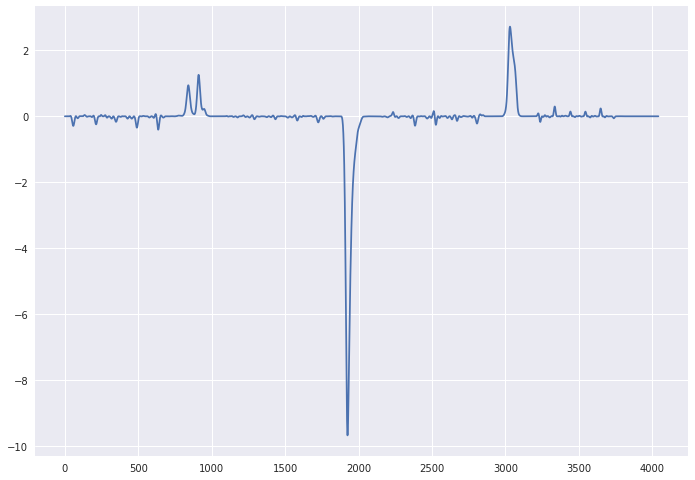

In [527]:
plt.plot(rrr)

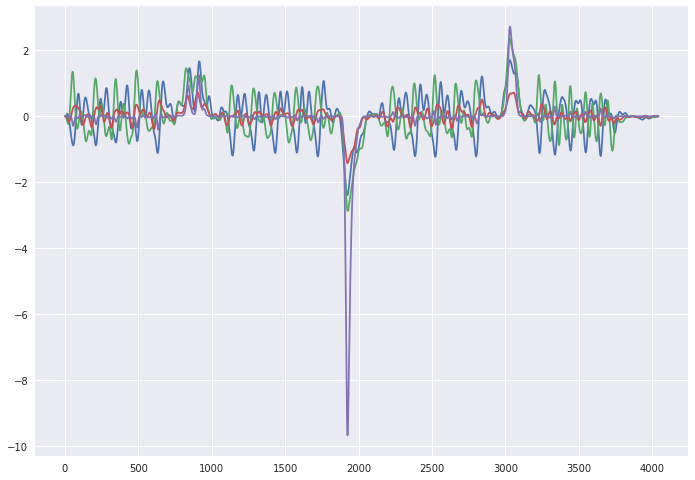

In [528]:
plt.plot(rr1)
plt.plot(rr2)
plt.plot(rr3)
plt.plot(rrr)

In [529]:
top = sig.argrelextrema(rrr, np.greater)[0]
bot = sig.argrelextrema(rrr, np.less)[0]

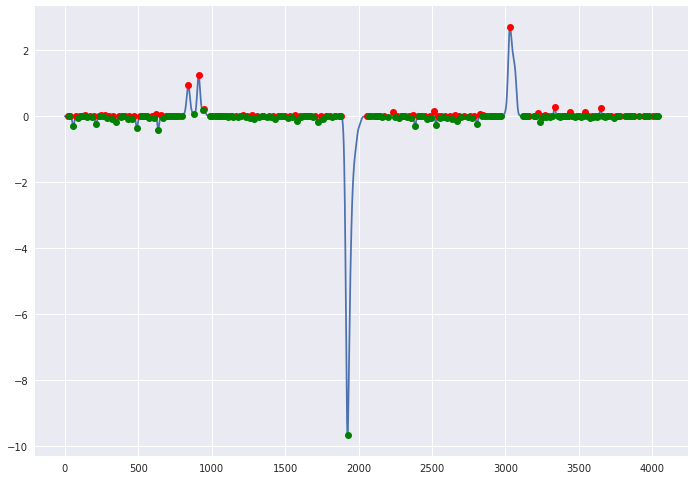

In [530]:
plt.plot(rrr)
plt.plot(top, rrr[top], 'ro')
plt.plot(bot, rrr[bot], 'go')

In [519]:
rrr[top]

array([1.66856312, 1.70292522])

In [514]:
top = top[rrr[top] > 1.5]
bot = bot[rrr[bot] < -1.5]

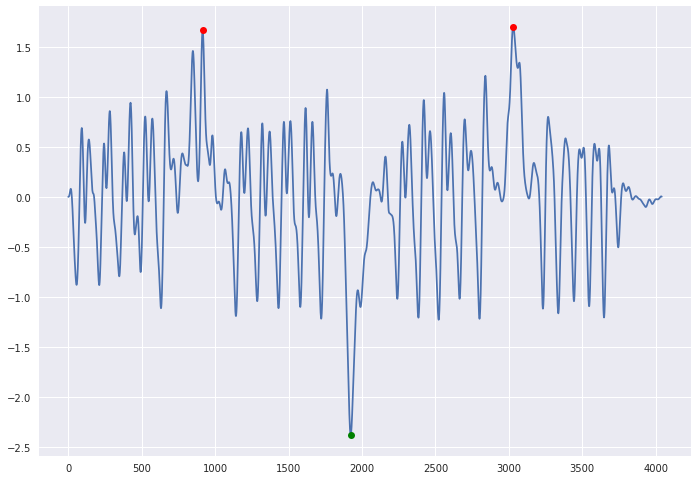

In [515]:
plt.plot(rrr)
plt.plot(top, rrr[top], 'ro')
plt.plot(bot, rrr[bot], 'go')

In [521]:
gyro_turns = np.sort(np.concatenate([top, bot]))

In [522]:
gyro_turns

array([ 915, 1923, 3029])

In [523]:
zero_crossings = np.where(np.diff(np.sign(rrr)))[0]

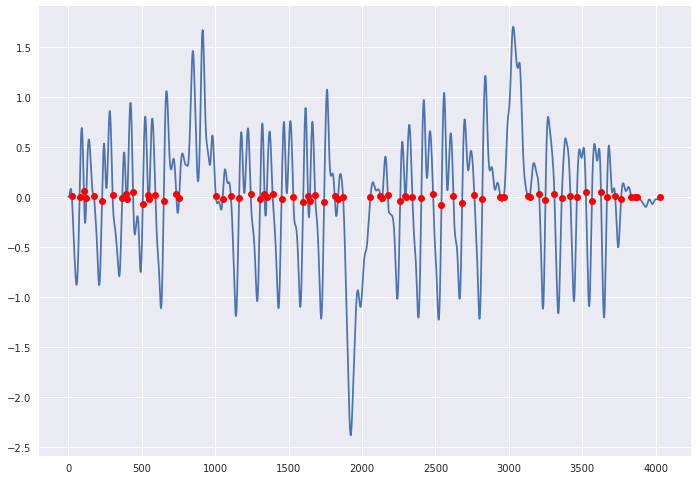

In [524]:
plt.plot(rrr)
plt.plot(zero_crossings, rrr[zero_crossings], 'ro')

In [496]:
start_turn_end = []

for t in gyro_turns:
    
    start = zero_crossings[np.where(zero_crossings < t)[0][-1]]
    stop = zero_crossings[np.where(zero_crossings > t)[0][0]]
    
    start_turn_end += [[start, t, stop]]

In [497]:
start_turn_end

[[756, 840, 989], [756, 910, 989], [1880, 1925, 2057], [2970, 3031, 3113]]

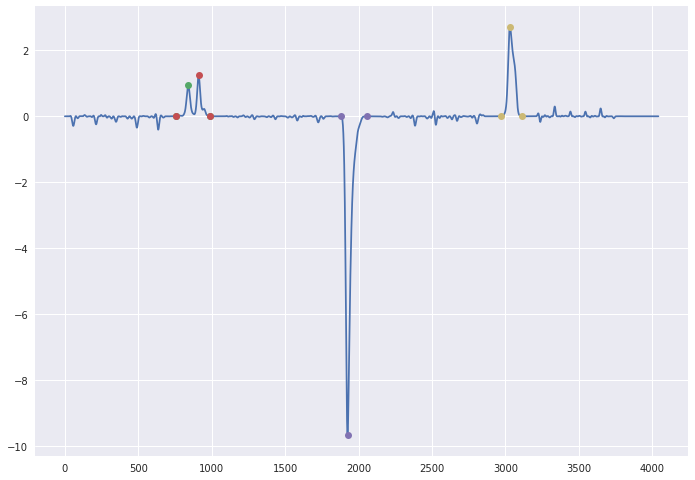

In [498]:
plt.plot(rrr)
for trn in start_turn_end:
    plt.plot(trn, rrr[trn], 'o')

In [499]:
for i in range(len(start_turn_end) - 1):
    if (start_turn_end[i][0] == start_turn_end[i+1][0]) and (start_turn_end[i][-1] == start_turn_end[i+1][-1]):
        start_turn_end[i+1] = [start_turn_end[i][0], start_turn_end[i][1], start_turn_end[i+1][1], start_turn_end[i][-1]]
        del start_turn_end[i]
        break
start_turn_end

[[756, 840, 910, 989], [1880, 1925, 2057], [2970, 3031, 3113]]

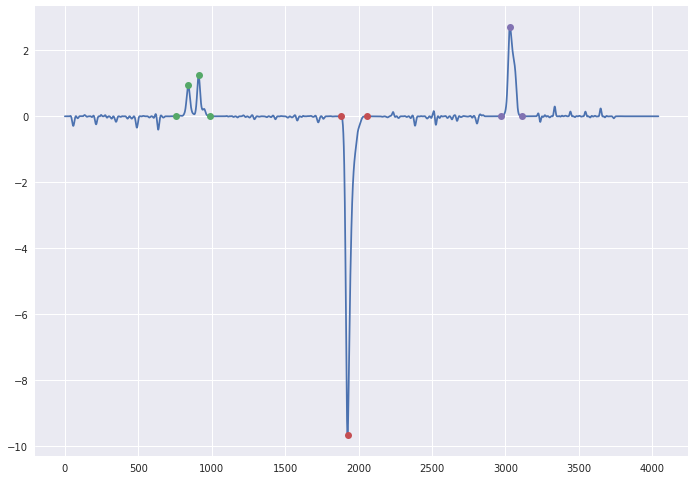

In [500]:
plt.plot(rrr)
for trn in start_turn_end:
    plt.plot(trn, rrr[trn], 'o')

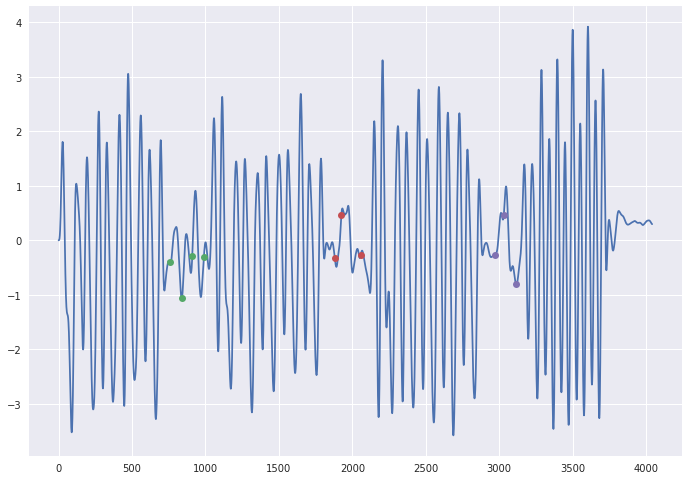

In [501]:
plt.plot(xx)
for trn in start_turn_end:
    plt.plot(trn, xx[trn], 'o')

In [502]:
for t in start_turn_end:
    print(t)
    print((t[-1] - t[0])  / 100 )
    the_time = newdata.td[t[0]: t[-1]].values
    the_time -= the_time[0]
    print(the_time[-1])

[756, 840, 910, 989]
2.33
2.3209999999999997
[1880, 1925, 2057]
1.77
1.7590000000000003
[2970, 3031, 3113]
1.43
1.421000000000003


In [511]:
start_turn_end

[[756, 840, 910, 989], [1880, 1925, 2057], [2970, 3031, 3113]]

Accel

take out data normalisation

collect the magic numbers

calculate hyperparameters, where possible

explain the algorithm: cleaning, filtering, signal processing, remove mini-peaks and merge peaks!

two versions:
    1. identify turning bits
    2. assume 10 (or 3) steps and infer turning
    
compare step counter with heel_strikes counter on test data

Gyro

look at the data again. don't use same approach

### Playing with FFT

In [541]:
ffsig = np.fft.rfft(df.x.values)

lowpass = 10
highpass = 200

ffsig[:lowpass] = 0
ffsig[80:120] = 0
ffsig[highpass:] = 0

plt.plot(np.fft.irfft(ffsig))

NameError: name 'df' is not defined

In [13]:
def get_peaks_valleys(data):
    """This will return top and bottom peaks, or peaks tops and valleys bottoms.
        
        :param data array: One-dimensional array.
        
        :return array top: The top peaks (peaks tops).
        :return array bot: The bottom peaks (valleys).
    """
    top = sig.argrelextrema(data, np.greater)[0]
    bot = sig.argrelextrema(data, np.less)[0]
    
    return top, bot

In [14]:
dd = df.y.values

In [15]:
top, bot = get_peaks_valleys(dd)

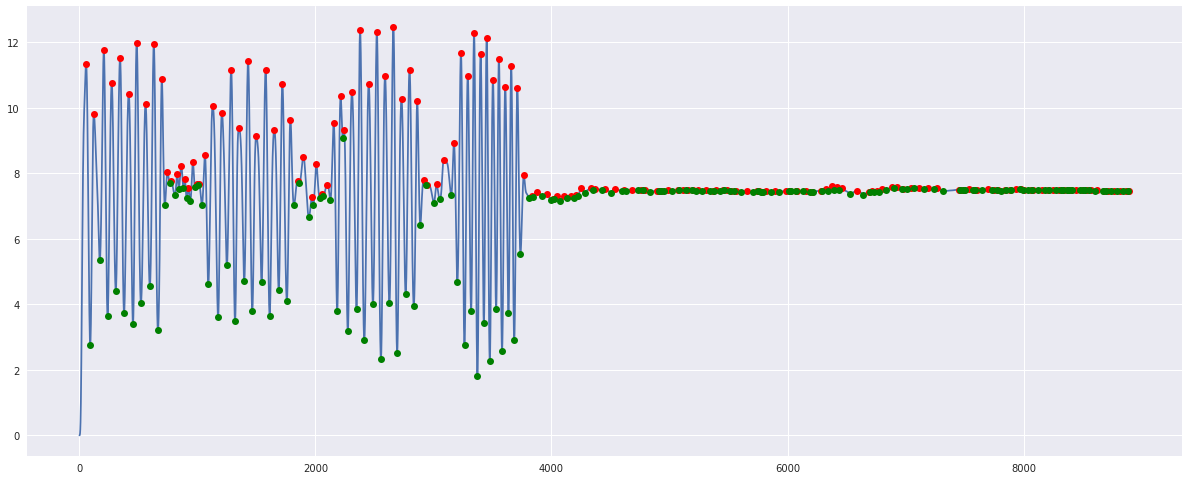

In [16]:
plt.plot(dd)
plt.plot(top, dd[top], 'ro')
plt.plot(bot, dd[bot], 'go')

Ok, that looks good, we will use the topographic prominence to determine where the signal starts and stops being interesting.

The rationale here is that we should start considering the signal interesting when walking begins and it should stop being interested when walking stops. To achieve this we will get the mean prominence and compare it with all the prominences, discarding those that are less than the mean. This works because walking exhibits bigger promimences than turning, and it will be larger than the mean of all prominences. 

We only search from the begining of the signal until the first occurence of a prominence that is larger than the mean, and stop. We will do the same from end to start. This will give us the walking and turning sections of the signal.

In [17]:
def get_peaks_prominences(data,):
    
    peaks, _ = get_peaks_valleys(data)
    prominences = sig.peak_prominences(data, peaks)[0]
    
    return peaks, prominences

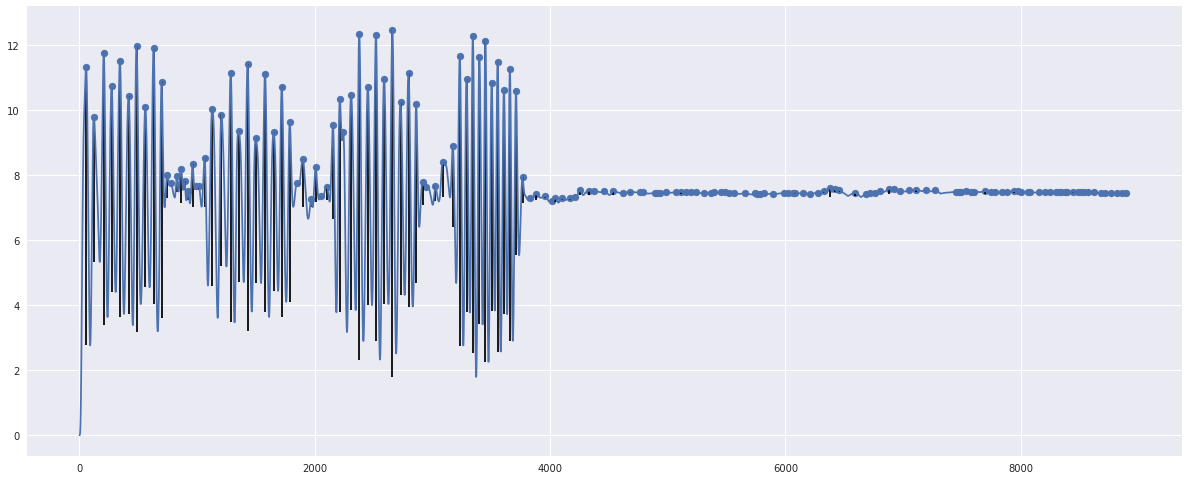

In [18]:
peaks, prominences = get_peaks_prominences(dd)

contour_heights = dd[peaks] - prominences
plt.plot(dd)
plt.scatter(peaks, dd[peaks])
plt.vlines(x=peaks, ymin=contour_heights, ymax=dd[peaks])

Here is the slicing function that will look at the prominences and remove the ones that are less than the mean prom.

In [133]:
start, stop = calculate_static_signal(df.x.values)
start, stop

(0, 4291)

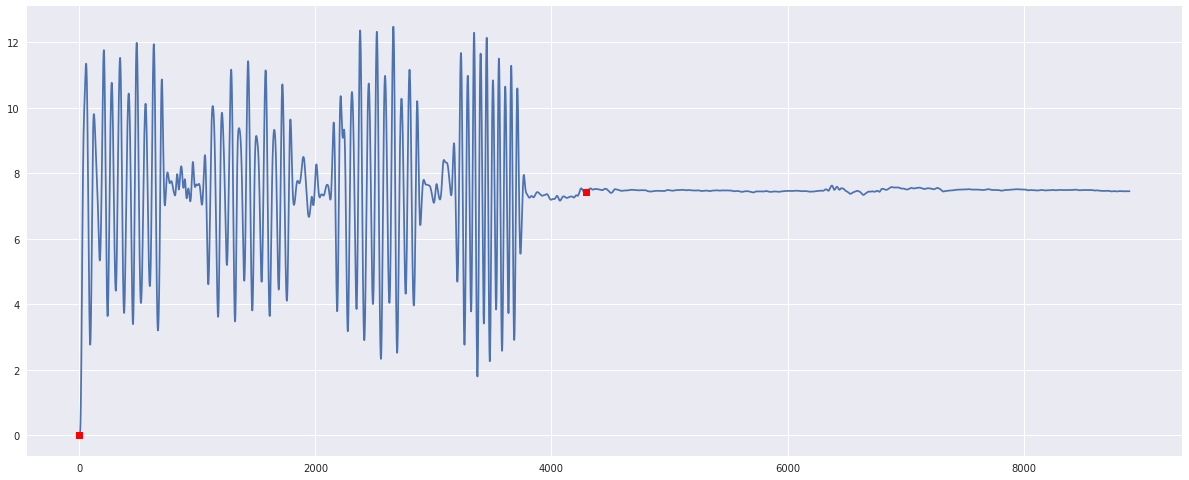

In [134]:
plt.plot(dd)
plt.plot(start, dd[start], 'rs')
plt.plot(stop, dd[stop], 'rs')

We have created a new convenience method to section the data_frame``, and it can be accessed through: ``gp.cut_data_frame(data_frame, start, stop)``. This method will reset the DateTime index of the dataframe and take care of the td (time difference) column.

In [135]:
df = gp.cut_data_frame(df, start=0, stop=stop)

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


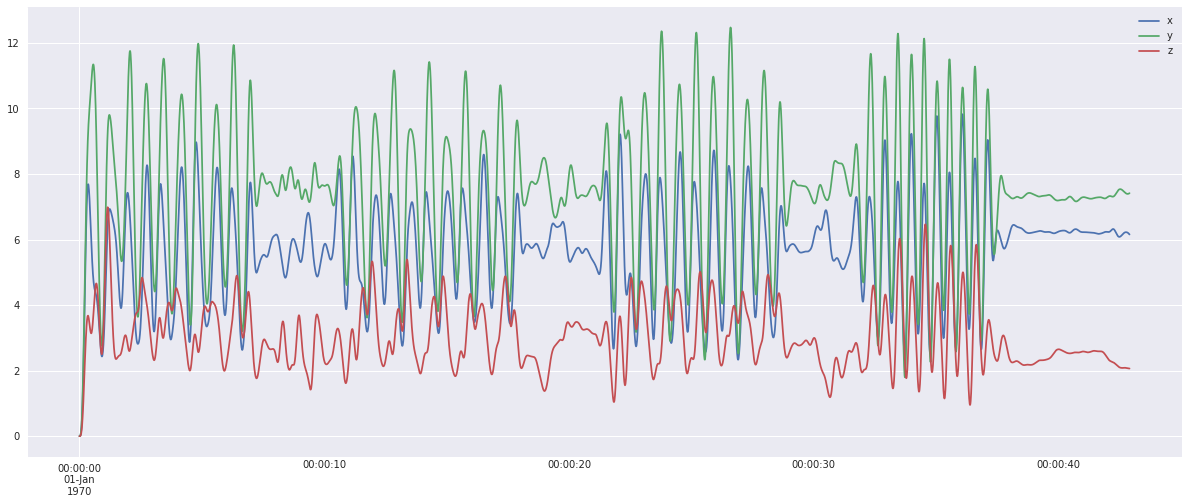

In [136]:
df[['x', 'y', 'z']].plot()